# 第6週：分析PTT美食版吃到飽相關文章之詞彙關係

本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以美食版吃到飽相關文章做為分析資料。


## 大綱
1. 套件說明 
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 計算TF-IDF示範（公式）
    - 3.2 應用於資料集（套件） 
    - 3.3 檢視結果
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5.  Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度
7. 補充：建立Ngram預測模型


## 1. 套件說明

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [6]:
# ％pip install -U networkx

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [8]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [9]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」
+ 時間: 2020-01-01 ~ 2022-12-31
+ 資料筆數：共 1630 篇文章

In [10]:
#匯入資料
df = pd.read_csv('./raw_data/zh_buffet_20_22.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt


### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [11]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...


### 2.3 文章斷詞與整理

In [12]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [13]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [14]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /Users/chialin/Documents/SMA助教/SMA_2024S/week6/dict/dict.txt.big ...
Dumping model to file cache /var/folders/jq/v_01fvx14g7g47h62d_98nl00000gn/T/jieba.u2ec9162f1c7c96d510c10a280615cd9f.cache
Loading model cost 0.661 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...,名稱
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...,咖哩


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 計算TF-IDF示範（公式）

#### 建立示範文件

In [15]:
# 一些短句子示範
doc1 = """中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存」政策，學生食物若被獼猴搶走，每次可向學校申請上限一百元補償金。
中山大學校園內近日張貼公告，宣導學生食物不外露，勿手拿會吸引獼猴搶奪的食物、提袋、塑膠袋或紙袋等，「如遇到獼猴掠食，先確保自身安全，放棄食物，避免在爭奪過程中受傷」。
校方於二至七月試辦補償措施，只要學生在柴山校區的商店購買食物被獼猴搶食，可到校內店家再次購買餐食，每人每餐補償上限為一百元，不過截至昨天為止，尚未有同學提出申請。"""

doc2 = """國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，滿足所有住宿學生的味蕾。
宿舍區同步升級多項軟硬體設施，包含逐步整修換新、定期辦理主題講座、職涯發展分享會、節慶交流活動、增設更多公共空間，並推動「衣服再利用」永續計畫，期能兼顧各種需求，提升住宿品質。
中山大學為方便住宿學生就近覓食，特地引進現煮拉麵熱食販賣機，於今年1月初進駐校園翠亨C棟、雨樹L棟及武嶺武二村聽濤堂前三個宿舍區點，鄰近自習室公共空間，提供大家更多選擇。"""

doc3 = """為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活動，打造練習外語聽說環境，使學生在中山便有機會認識世界、擴展視野，
在全球化下能海納百川，欣賞多國多語言的多元文化。「在中山說第二外語」語言交換活動獲文學院與國際事務處支持推廣，學生參與踴躍，2場次參加人數達70人次，
其中多達半數為非外文系學生，參與外籍生亦來自歐、亞、美洲等不同國家，活動中以德文、法文、西班牙文、日文及韓文使用者為大宗。"""

sample_df = pd.DataFrame({'doc':[1,2,3], 'text': [doc1, doc2, doc3]})

sample_df

,doc,text
0,1,中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存...
1,2,國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，...
2,3,為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活...


資料清理

In [16]:
sample_df['text'] = sample_df['text'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
sample_df = sample_df.assign(word = sample_df['text'].apply(getToken)).explode('word')

sample_df.head()

,doc,text,word
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,中山大學
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,位於
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,高雄
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,山地區
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,野生


#### 計算各文章的總詞彙數

In [17]:
total_words = sample_df.groupby(['doc'], as_index=False).size().rename(columns={'size': 'total'})
total_words.head()

,doc,total
0,1,80
1,2,76
2,3,68


#### 計算各文章的各個詞彙數

In [18]:
word_count = sample_df.groupby(['doc', 'word'], as_index = False).size()

word_count.rename(columns={'size': 'count'}, inplace=True)
word_count.sort_values('count', ascending=False).head()

,doc,word,count
57,1,食物,6
46,1,獼猴,6
17,1,學生,5
64,2,住宿,4
141,3,外語,4


合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [19]:
sample_merged = word_count.merge(total_words, on = 'doc', how = 'left')
sample_merged.head(3)

,doc,word,count,total
0,1,一百元,2,80
1,1,七月,1,80
2,1,上限,2,80


#### 計算 TF值

In [20]:
# 計算tf = 詞彙在該文件中出現次數 / 該文件中詞彙總數 
sample_tf_idf = sample_merged.assign(tf = sample_merged["count"] / sample_merged["total"])
sample_tf_idf.head()

,doc,word,count,total,tf
0,1,一百元,2,80,0.0250
1,1,七月,1,80,0.0125
2,1,上限,2,80,0.0250
3,1,中山大學,2,80,0.0250
4,1,二至,1,80,0.0125


#### 計算 IDF值

In [21]:
# 計算每個詞彙出現在幾篇文章中
idf_df = sample_merged.groupby(['word'], as_index = False).size()

# 合併到之前的df中
sample_tf_idf = sample_tf_idf.merge(idf_df, on = 'word', how = 'left')

sample_tf_idf.head()

,doc,word,count,total,tf,size
0,1,一百元,2,80,0.0250,1
1,1,七月,1,80,0.0125,1
2,1,上限,2,80,0.0250,1
3,1,中山大學,2,80,0.0250,3
4,1,二至,1,80,0.0125,1


In [22]:
# 計算idf = log( 總文件數量 / 包含該詞彙的文件數量 ) 
sample_tf_idf = sample_tf_idf.assign(idf = sample_tf_idf["size"].apply(lambda size: math.log( len(total_words) / size, 10 ))).drop(["size"], axis=1)

sample_tf_idf.head()

,doc,word,count,total,tf,idf
0,1,一百元,2,80,0.0250,0.477121
1,1,七月,1,80,0.0125,0.477121
2,1,上限,2,80,0.0250,0.477121
3,1,中山大學,2,80,0.0250,0.000000
4,1,二至,1,80,0.0125,0.477121


#### 計算 TFIDF值

In [23]:
# 計算tf*idf
sample_tf_idf = sample_tf_idf.assign(tf_idf = sample_tf_idf["tf"] * sample_tf_idf["idf"])

sample_tf_idf.sort_values('tf_idf', ascending = False).head(10)

,doc,word,count,total,tf,idf,tf_idf
57,1,食物,6,80,0.075000,0.477121,0.035784
46,1,獼猴,6,80,0.075000,0.477121,0.035784
141,3,外語,4,68,0.058824,0.477121,0.028066
64,2,住宿,4,76,0.052632,0.477121,0.025112
124,3,中山,3,68,0.044118,0.477121,0.021049
160,3,活動,3,68,0.044118,0.477121,0.021049
169,3,語言,3,68,0.044118,0.477121,0.021049
99,2,空間,3,76,0.039474,0.477121,0.018834
139,3,外文系,2,68,0.029412,0.477121,0.014033
134,3,參與,2,68,0.029412,0.477121,0.014033


In [24]:
# 選出每個文件，tf-idf值最大的前三個詞
group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))
group

/var/folders/jq/v_01fvx14g7g47h62d_98nl00000gn/T/ipykernel_43259/1751358733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))


doc word  count  total        tf       idf    tf_idf
doc                                                          
1   46     1   獼猴      6     80  0.075000  0.477121  0.035784
    57     1   食物      6     80  0.075000  0.477121  0.035784
    0      1  一百元      2     80  0.025000  0.477121  0.011928
2   64     2   住宿      4     76  0.052632  0.477121  0.025112
    99     2   空間      3     76  0.039474  0.477121  0.018834
    65     2   公共      2     76  0.026316  0.477121  0.012556
3   141    3   外語      4     68  0.058824  0.477121  0.028066
    124    3   中山      3     68  0.044118  0.477121  0.021049
    160    3   活動      3     68  0.044118  0.477121  0.021049

### 3.2 應用於資料集（套件）

除了直接用公式計算，也可以使用sklearn中計算詞頻與tf-idf的套件。

DTM 介紹
- Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。   
- DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。

舉例來說，若有三個文件其內容如下：
- 文件1：「今天天氣很好」
- 文件2：「今天是星期五」
- 文件3：「昨天是星期四而且天氣很好」

而這些文件斷完詞後的結果可能為：
- 文件1：「今天／天氣／很／好」
- 文件2：「今天／是／星期五」
- 文件3：「昨天／是／星期四／而且／天氣／很／好」

將這三個文件以DTM格式表示則如下圖：   

<img src="./img/DTM_exsample.png" style="float:left;" width="70%">   

In [25]:
food_df = MetaData.copy()
food_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...


In [26]:
# 保留需要的欄位
food_df = food_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
food_df['word'] = food_df.sentence.apply(getToken).map(' '.join)

food_df.head()

,system_id,sentence,word
0,1,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳 名稱 咖哩 消費 時間 例年 提供 文章 不予 保留 多訪 綜合 心得 標上 時間 地...
1,2,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...,餐廳 名稱 乾杯 地址 乾杯 電話 消費 時間 年月號 事發 元旦 女朋友 晚上 會點 牛排...
2,3,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...,餐廳 名稱 小慧涼 消費 時間 起多訪 地址 台北市 大安區 臥龍 街巷 電話 營業時間 週...
3,4,消費時間年月在運河城逛累了當然要吃東西補充體力了喔最大的特色就是有包廂的設計不只提供中文菜單...,消費 時間 運河 城逛 東西 補充 體力 特色 包廂 設計 提供 中文 菜單 點餐 無障礙 ...
4,5,店名長榮皇璽桂冠艙飛機餐地址無電話無營業時間依機艙供餐時間為準個人平均消費依機票價格為主適合...,店名 長榮 皇璽 桂冠 飛機 地址 電話 營業時間 機艙 供餐 時間 為準 平均 消費 機票...


In [27]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一一列舉,一丁,一丁點,一上,一上鍋,一下下,一下二十,一下子,一下肚子,...,龍騰,龍骨,龍鬚,龍鬚菜,龍鳳,龐然大物,龜子,龜山,龜苓膏,龜速
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一一列舉,一丁,一丁點,一上,一上鍋,一下下,一下二十,一下子,一下肚子,...,龍騰,龍骨,龍鬚,龍鬚菜,龍鳳,龐然大物,龜子,龜山,龜苓膏,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [ ]:
food_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
food_tfidf.columns = ["word", "avg"]

food_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
27449,火鍋,0.027030
1660,不錯,0.024806
13543,好吃,0.023565
30390,用餐,0.023428
46735,餐廳,0.022265
31565,真的,0.021121
29305,牛肉,0.021029
20064,提供,0.020896
29217,牛排,0.020683
28603,燒肉,0.019887


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [30]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一一列舉,一丁,一丁點,一上,一上鍋,一下下,一下二十,一下子,...,龍騰,龍骨,龍鬚,龍鬚菜,龍鳳,龐然大物,龜子,龜山,龜苓膏,龜速
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626,1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1627,1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628,1629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
79553775,1626,龜速,0.0
79553776,1627,龜速,0.0
79553777,1628,龜速,0.0
79553778,1629,龜速,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [32]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/var/folders/jq/v_01fvx14g7g47h62d_98nl00000gn/T/ipykernel_43259/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
4153,火鍋,122
4363,燒肉,110
4457,牛排,104
6779,韓式,89
1903,壽司,86
2117,套餐,80
4245,烤肉,61
3029,提供,57
7184,麻辣鍋,55
5705,蛋糕,50


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

N-gram範例：

In [33]:
token = jieba.lcut("中山資管全國第一")
token

['中山', '資管', '全國', '第一']

In [34]:
# 利用nltk的ngrams()
# Bigram
bigram  = ngrams(token, 2)
list(bigram)

[('中山', '資管'), ('資管', '全國'), ('全國', '第一')]

In [35]:
# Trigram
trigram  = ngrams(token, 3)
list(trigram)

[('中山', '資管', '全國'), ('資管', '全國', '第一')]

### 4.1 Bigram

In [36]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [37]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
food_bigram = food_bigram.explode('word')

food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳 名稱
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費


#### 統計最常出現的bigram組合

In [38]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram['word'].value_counts().reset_index()

food_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,電話 營業時間,1271
1,消費 時間,1169
2,餐廳 名稱,1076
3,時間 地址,1024
4,平均 價位,766
5,每人 平均,759
6,可否 刷卡,619
7,服務 人員,600
8,地址 台北市,500
9,有無 包廂,499


### 4.2 Trigram

In [39]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
food_trigram = food_trigram.explode('word')

food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳 名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,名稱 咖哩 消費
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費 時間


#### 統計最常出現的trigram組合

In [40]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram['word'].value_counts().reset_index()

food_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,消費 時間 地址,999
1,每人 平均 價位,750
2,刷卡 有無 包廂,432
3,可否 刷卡 有無,427
4,價位 可否 刷卡,396
5,平均 價位 可否,392
6,時間 地址 台北市,288
7,營業時間 每人 平均,273
8,電話 營業時間 每人,268
9,包廂 推薦 菜色,248


從上面的 bigram 和 trigram 的結果中，我們發現"餐廳 名稱"、"服務 人員"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 4.3 使用自建字典

In [41]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/buffet_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [42]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,消費


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [43]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱 咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,咖哩 消費
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,消費 時間


In [44]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('電話', '營業時間'), 1271),
 (('消費', '時間'), 1169),
 (('時間', '地址'), 1024),
 (('平均', '價位'), 766),
 (('每人', '平均'), 759)]

除了利用N-gram來幫助建立斷詞字典，N-gram也能幫助我們發現詞與詞之間的連貫關係。

接下來針對重新斷詞後的bigram出現頻率最高的前50對進行視覺化，觀察文章的關鍵詞對

In [45]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

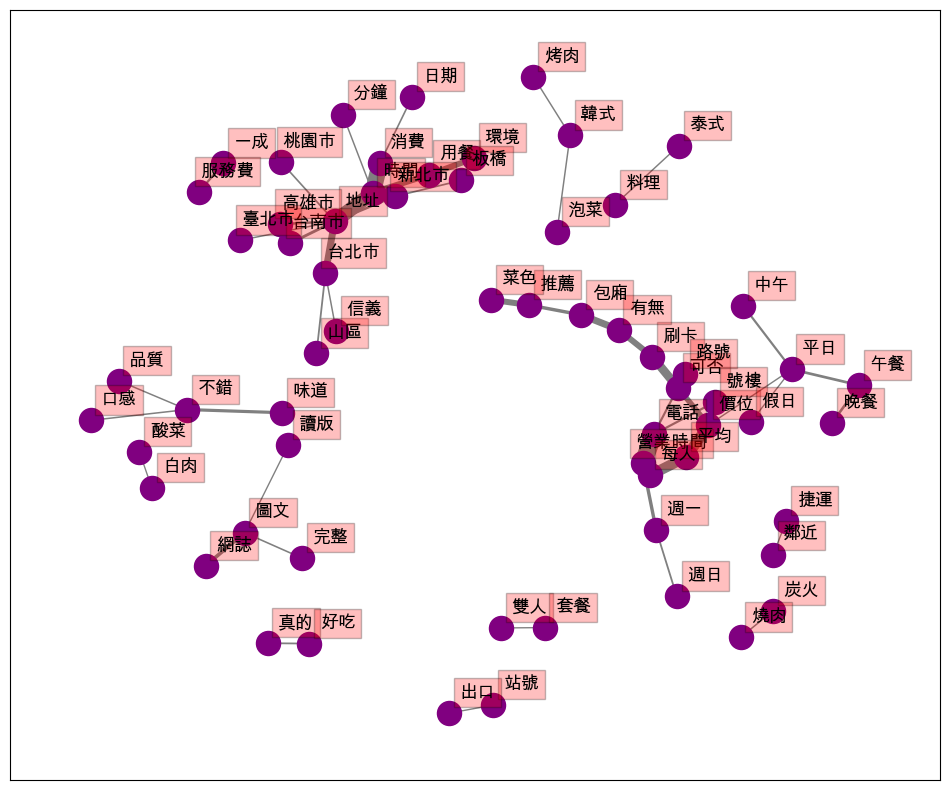

In [47]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

使用[numpy.corrcoef](https://numpy.org/doc/2.2/reference/generated/numpy.corrcoef.html)的方法計算

In [48]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱 咖哩 消費 時間 例年 提供 文章 不予 保留 多訪 綜合 心得 標上 時間 地址...
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...,餐廳名稱 乾杯 地址 乾杯 電話 消費 時間 年月號 事發 元旦 女朋友 晚上 會點 牛排 ...
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...,餐廳名稱 小慧 涼麵 消費 時間 起多訪 地址 台北市 大安區 臥龍 街巷 電話 營業時間 ...


In [49]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,上桌,下午茶,不錯,中午,主打,乾淨,五花,享用,介紹,份量,...,餐點,香氣,高麗菜,鮭魚,鮮甜,鮮蝦,麻辣,麻辣鍋,點餐,龍蝦
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,2,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,0,1,0,0,0,0,1,0,1,...,3,0,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,0,0,1,1,0,0,0,0,2,2,...,2,0,1,0,0,0,0,0,0,0
1627,0,0,5,0,0,0,0,0,0,2,...,3,1,0,0,3,0,1,0,1,0
1628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [50]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,上桌,下午茶,不錯,中午,主打,乾淨,五花,享用,介紹,...,餐點,香氣,高麗菜,鮭魚,鮮甜,鮮蝦,麻辣,麻辣鍋,點餐,龍蝦
0,上桌,1.000000,-0.050623,0.087623,-0.022908,0.060764,0.009400,0.034675,0.103761,0.116357,...,0.250774,0.130739,0.004199,0.010593,0.077065,0.111693,0.034206,0.092355,0.244062,0.067678
1,下午茶,-0.050623,1.000000,0.106970,-0.042402,0.055799,-0.046384,-0.063691,-0.021133,-0.002267,...,0.184399,-0.023190,-0.011788,0.252115,0.037368,0.073884,-0.039335,-0.034198,-0.053984,0.060931
2,不錯,0.087623,0.106970,1.000000,0.134682,0.050302,0.043113,0.133771,0.117400,0.068478,...,0.278762,0.123956,0.041989,0.130894,0.144954,0.146749,0.043606,0.022388,0.104621,0.041809
3,中午,-0.022908,-0.042402,0.134682,1.000000,0.042736,0.010551,0.139429,0.065736,0.075898,...,-0.016541,0.033856,0.010817,0.062699,0.034574,-0.050222,0.010921,0.004767,-0.015162,0.051435
4,主打,0.060764,0.055799,0.050302,0.042736,1.000000,0.051891,0.071856,0.058936,0.060325,...,0.033706,0.101172,0.021301,0.111589,0.119277,0.009878,0.053026,0.047324,0.022044,0.066000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,鮮蝦,0.111693,0.073884,0.146749,-0.050222,0.009878,0.012943,-0.036892,0.005086,0.042558,...,0.145869,0.090353,0.048389,0.143916,0.098173,1.000000,0.034402,0.007843,0.044704,0.054312
296,麻辣,0.034206,-0.039335,0.043606,0.010921,0.053026,0.080629,0.106848,0.073849,0.091329,...,-0.016741,0.106065,0.057156,-0.034941,0.071445,0.034402,1.000000,0.383397,0.069291,-0.003900
297,麻辣鍋,0.092355,-0.034198,0.022388,0.004767,0.047324,0.048360,0.086489,0.087964,0.018911,...,-0.037239,0.092525,-0.003568,-0.038875,0.109459,0.007843,0.383397,1.000000,0.105305,-0.016802
298,點餐,0.244062,-0.053984,0.104621,-0.015162,0.022044,0.050103,0.051495,0.090279,0.099527,...,0.139940,0.063806,-0.003444,0.008190,0.059733,0.044704,0.069291,0.105305,1.000000,-0.013805


In [51]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
20974,電話,地址,0.984201
82269,地址,電話,0.984201
20881,營業時間,地址,0.949483
54369,地址,營業時間,0.949483
82381,營業時間,電話,0.942925
54574,電話,營業時間,0.942925
54410,捷運,營業時間,0.912229
33181,營業時間,捷運,0.912229
36142,板橋,新北市,0.906233
42720,新北市,板橋,0.906233


### 5.1 和 「冰淇淋」, 「韓式」 相關性最高的 10 個詞彙

In [52]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "冰淇淋")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "韓式")].sort_values(by = ['cor'], ascending = False).head(10)

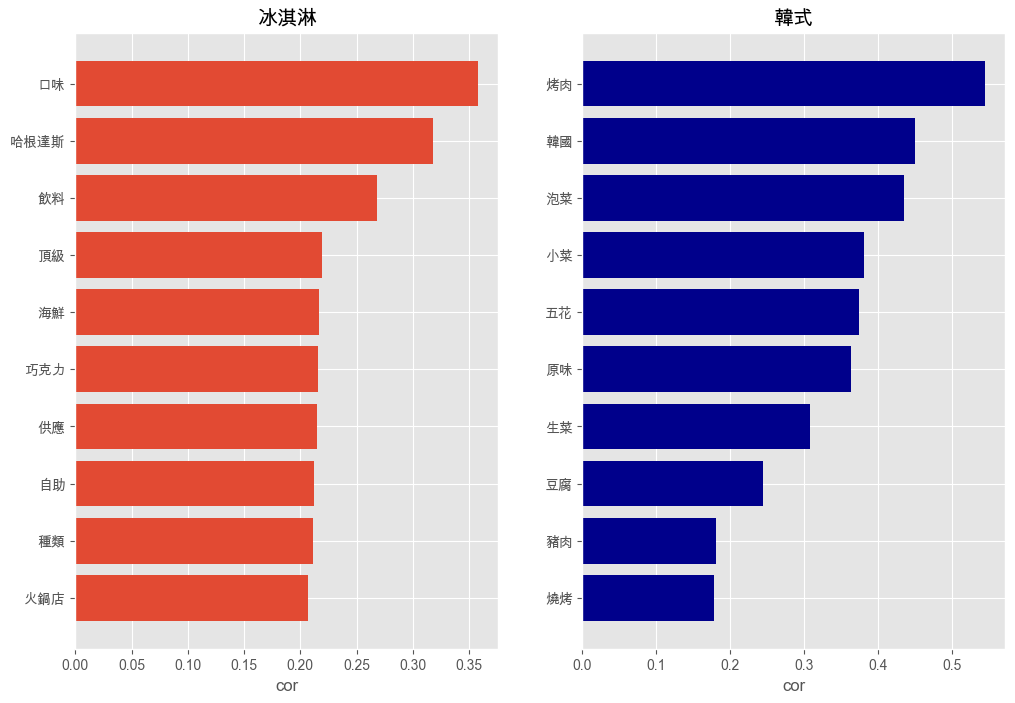

In [53]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('冰淇淋')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('韓式')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [54]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [55]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,口感,不錯,0.387493
1,味道,不錯,0.539663
2,喜歡,不錯,0.329306
3,好吃,不錯,0.381029
4,感覺,不錯,0.483832
...,...,...,...
135,平均,餐廳名稱,0.339953
136,每人,餐廳名稱,0.330878
137,消費,餐廳名稱,0.474064
138,味道,餐點,0.313772


In [56]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

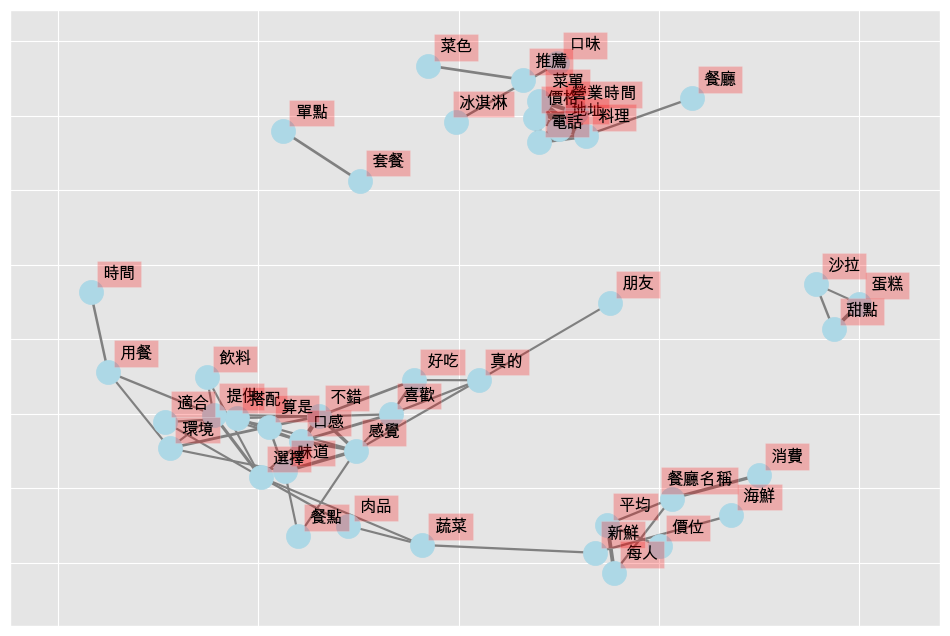

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [58]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月未提供則文章不予保留多訪綜合心得也請標上起迄時間地址台北市開...,餐廳名稱 咖哩 消費 時間 例年 提供 文章 不予 保留 多訪 綜合 心得 標上 時間 地址...
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯地址乾杯電話消費時間年月號事發經過元旦跟女朋友晚上訂了位以前都會點上等牛排吃過很...,餐廳名稱 乾杯 地址 乾杯 電話 消費 時間 年月號 事發 元旦 女朋友 晚上 會點 牛排 ...
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱小慧涼麵消費時間年月起多訪地址台北市大安區臥龍街巷號電話營業時間週日公休每人平均價位...,餐廳名稱 小慧 涼麵 消費 時間 起多訪 地址 台北市 大安區 臥龍 街巷 電話 營業時間 ...


In [59]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,上桌,下午茶,不錯,中午,主打,乾淨,五花,享用,介紹,份量,...,餐點,香氣,高麗菜,鮭魚,鮮甜,鮮蝦,麻辣,麻辣鍋,點餐,龍蝦
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.207893,0.0
2,0.061366,0.000000,0.000000,0.134076,0.0,0.0,0.0,0.000000,0.060597,0.050009,...,0.047189,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.213433,0.0
4,0.000000,0.000000,0.043683,0.000000,0.0,0.0,0.0,0.079645,0.000000,0.063695,...,0.180311,0.000000,0.000000,0.0,0.092916,0.195397,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,0.000000,0.256822,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1626,0.000000,0.000000,0.024500,0.047889,0.0,0.0,0.0,0.000000,0.086575,0.071448,...,0.067419,0.000000,0.045714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1627,0.000000,0.000000,0.128897,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.075179,...,0.106410,0.043179,0.000000,0.0,0.164501,0.000000,0.051222,0.000000,0.051800,0.0
1628,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.436489,0.000000,0.0


計算文章間的cosine similarity

In [60]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [ ]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.034102
2,0.087085
3,0.047096
4,0.037184
...,...
1625,0.024851
1626,0.065243
1627,0.058521
1628,0.079000


In [62]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[食記]台北中正濃咖哩平價美味份量大,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...
824,0.900569,[食記]台南老騎士咖哩飯專門店免費加飯湯菜,https://www.ptt.cc/bbs/Food/M.1614905274.A.EE8...
281,0.894575,[食記]台中家咖哩，台自花蓮的人氣美食,https://www.ptt.cc/bbs/Food/M.1591209440.A.1CA...
766,0.867962,[食記]台中家咖哩給你家的溫度,https://www.ptt.cc/bbs/Food/M.1612413995.A.111...
587,0.862830,[食記]台南老騎士咖哩飯白飯/小菜/飲料吃到飽,https://www.ptt.cc/bbs/Food/M.1605011773.A.6EB...
1050,0.817578,[食記]台南東區咖哩大叔日式咖哩專賣店,https://www.ptt.cc/bbs/Food/M.1631545003.A.F5E...
1523,0.801990,[食記]台北中山十巷咖哩飯醬無限續吃到飽,https://www.ptt.cc/bbs/Food/M.1663577130.A.E49...
1428,0.798627,[食記]台北東區TAJ泰姬印度餐廳：一人塔麗套餐,https://www.ptt.cc/bbs/Food/M.1655819517.A.78E...
1013,0.568795,[食記][新北][板橋]和牛涮/外帶高CP值火鍋/餐,https://www.ptt.cc/bbs/Food/M.1627788326.A.D8D...
535,0.544099,[食記]南投埔里不靠海~巷弄內的溫馨小店,https://www.ptt.cc/bbs/Food/M.1602574086.A.86A...


檢視與第14篇文章相似的文章

In [63]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
14,1.000000,[食記]高雄好好吃肉韓式烤肉吃到飽食肉怪必吃,https://www.ptt.cc/bbs/Food/M.1578797582.A.B58...
596,0.534594,[食記]台南咚豬咚豬韓國烤肉吃到飽299元,https://www.ptt.cc/bbs/Food/M.1605110983.A.C91...
1365,0.523025,[食記]台中豬對有韓式烤肉吃到飽逢甲店,https://www.ptt.cc/bbs/Food/M.1652364909.A.02B...
1373,0.514020,[食記]台南東區韓國先生部隊鍋199元吃到飽,https://www.ptt.cc/bbs/Food/M.1652698005.A.18E...
611,0.490053,[食記]台北TaeBak大發韓式特色料理,https://www.ptt.cc/bbs/Food/M.1605719023.A.717...
597,0.489402,[食記]新北中和金花子韓式料理永安市場店,https://www.ptt.cc/bbs/Food/M.1605117838.A.4C8...
810,0.488041,[食記]台南八道晟韓式火烤兩吃每人299元,https://www.ptt.cc/bbs/Food/M.1614436013.A.DDE...
506,0.485782,Fw:[食記]金門---檸檬香茅韓國烤肉吃到飽,https://www.ptt.cc/bbs/Food/M.1601478772.A.343...
255,0.484636,[食記]高雄首爾韓國食堂高師大旁人氣韓國料理,https://www.ptt.cc/bbs/Food/M.1590309814.A.B0A...
326,0.482631,[食記]高雄八道晟-299韓式火烤吃到飽又一發,https://www.ptt.cc/bbs/Food/M.1593185191.A.F19...


## 7. 補充：建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

---
**以Bi-gram為例：中山＿＿該填甚麼?**  
[ ["中山","資管","全國","第一"],  ["歡迎","來到","中山","大學"],  ["中山","資管","碩士","開放","報名"] ]  
$$ p(w|中山) = \frac {count(中山,w)} {count(中山)} $$
           
$$ p(資管|中山) = \frac {2} {3} $$
$$ p(大學|中山) = \frac {1} {3} $$

In [64]:
test_list = [["中山","資管","全國","第一"],
             ["歡迎","來到","中山","大學"],
             ["中山","資管","碩士","開放","報名"]]

In [65]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    # 加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    total_grams = total_grams + list(ngrams(split_words, N))
    print(total_grams)
    # 計算分母
    words = words + list(ngrams(split_words, N-1))
    print(words)
    print('')
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>'), ('<s>', '中山'), ('中山', '資管'), ('資管', '碩士'), ('碩士', '開放'), ('開放', '報名'), ('報名', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',), ('<s>',), ('中山',), ('資管',), ('碩士',), ('開放',), ('報名',), ('</s>',)]



In [66]:
# 分子
total_word_counter

Counter({('<s>', '中山'): 2,
         ('中山', '資管'): 2,
         ('資管', '全國'): 1,
         ('全國', '第一'): 1,
         ('第一', '</s>'): 1,
         ('<s>', '歡迎'): 1,
         ('歡迎', '來到'): 1,
         ('來到', '中山'): 1,
         ('中山', '大學'): 1,
         ('大學', '</s>'): 1,
         ('資管', '碩士'): 1,
         ('碩士', '開放'): 1,
         ('開放', '報名'): 1,
         ('報名', '</s>'): 1})

In [67]:
# 分母
word_counter

Counter({('<s>',): 3,
         ('中山',): 3,
         ('</s>',): 3,
         ('資管',): 2,
         ('全國',): 1,
         ('第一',): 1,
         ('歡迎',): 1,
         ('來到',): 1,
         ('大學',): 1,
         ('碩士',): 1,
         ('開放',): 1,
         ('報名',): 1})

In [68]:
for key in total_word_counter:
    word = ''.join(key[:N-1])
    if word not in ngram_prediction:
        ngram_prediction.update({word: set()})

    # 算出預測機率，新增至 ngram_prediction
    next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
    w = Word(key[-1], '{:.3g}'.format(next_word_prob))
    ngram_prediction[word].add(w)

In [69]:
ngram_prediction

{'<s>': {Word(word='中山', prob='0.667'), Word(word='歡迎', prob='0.333')},
 '中山': {Word(word='大學', prob='0.333'), Word(word='資管', prob='0.667')},
 '資管': {Word(word='全國', prob='0.5'), Word(word='碩士', prob='0.5')},
 '全國': {Word(word='第一', prob='1')},
 '第一': {Word(word='</s>', prob='1')},
 '歡迎': {Word(word='來到', prob='1')},
 '來到': {Word(word='中山', prob='1')},
 '大學': {Word(word='</s>', prob='1')},
 '碩士': {Word(word='開放', prob='1')},
 '開放': {Word(word='報名', prob='1')},
 '報名': {Word(word='</s>', prob='1')}}

**使用我們的吃到飽資料集**

In [70]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [71]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [72]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [73]:
text = '喜歡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 口味, probability: 0.0149
next word: 朋友, probability: 0.0116
next word: 口感, probability: 0.00993
next word: 海鮮, probability: 0.00993
next word: 牛肉, probability: 0.0091


In [74]:
text = '提供'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 白飯, probability: 0.0167
next word: 免費, probability: 0.0116
next word: 口味, probability: 0.00988
next word: 兒童, probability: 0.00945
next word: 食材, probability: 0.00859
